In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import os
import tensorly as tl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorly.decomposition import matrix_product_state

In [3]:
import cv2
from imageio import imread
from functools import partial
from skimage.metrics import (
    structural_similarity as ssim,
    peak_signal_noise_ratio as psnr,
)

ssim = partial(ssim, channel_axis=-1)

## Image Denoising via Low-Rank Tensor Decomposition

We can reformulate the image denoising problem in the following way:

$$
\begin{align}
\min \quad & \lVert \mathcal{Y} - \mathcal{X} \rVert_F^{2}\\
\text{s.t.} \quad & \mathcal{X} \text{ is low-rank}
\end{align}
$$

Here $\mathcal{Y}$ is the noisy image tensor and $\mathcal{X}$ is its denoised version.

We will make use of ADMM (alternating direction method of multipliers) to solve the above constrained optimization problem. Introduce an indicator function $i_{LR}(\mathcal{X}) = \mathbb{I}\left\{\mathcal{X} \text{ is low-rank}\right\}$ and auxiliary tensor $\mathcal{Z}$. Reformulate the optimization problem:

$$
\begin{align}
\min \quad & \lVert \mathcal{Y} - \mathcal{X} \rVert_F^{2} + i_{LR}(\mathcal{Z})\\
\text{s.t.} \quad & \mathcal{X} - \mathcal{Z} = 0 
\end{align}
$$

The augmented Lagrangian ($\mathcal{T}$ is a tensor of scaled dual variables) has the following form:

$$
\mathcal{L}_{\rho}(\mathcal{X}, \mathcal{Z}, \mathcal{T}) =  \lVert \mathcal{Y} - \mathcal{X} \rVert_F^{2} + i_{LR}(\mathcal{Z}) + \frac{\rho}{2} \lVert \mathcal{X} - \mathcal{Z} + \mathcal{T} \rVert_F^{2} 
$$

One can now rewrite the one step of the optimization procedure:

$$
\mathcal{X}^{(k+1)} = \textbf{prox}_{1/\rho, \lVert \cdot \rVert_F^2 } \left( \mathcal{Z}^{(k)} - \mathcal{T}^{(k)} \right) = \argmin_{\mathcal{X}} \; \lVert \mathcal{Y} - \mathcal{X} \rVert_F^{2} + \frac{\rho}{2} \lVert \mathcal{X} - \mathcal{Z}^{(k)} + \mathcal{T}^{(k)} \rVert_F^{2} \\
\mathcal{Z}^{(k+1)} = \Pi_{\text{low-rank}} \left(\mathcal{X}^{(k+1)} +  \mathcal{T}^{(k)}\right) \\
\mathcal{T}^{(k+1)} = \mathcal{T}^{(k)} + \left(\mathcal{X}^{(k+1)} -  \mathcal{Z}^{(k+1)}\right)
$$

In order to explicitly write the proximal operator we have to solve:
$$
\argmin_{\mathcal{X}} \; \lVert \mathcal{Y} - \mathcal{X}\rVert_F^{2} + \frac{\rho}{2} \lVert \mathcal{X} - \mathcal{Z} + \mathcal{T}\rVert_F^{2}
$$

Introduce new variables $\mathcal{U} = \left(\mathcal{X} -  \mathcal{Y}\right)$ and $\mathcal{V} = \left(\mathcal{Z} -  \mathcal{Y} -  \mathcal{T}\right)$. The above objective can now be reformulated (later we can recover $\mathcal{X} = \mathcal{U} + \mathcal{Y}$)
$$
\argmin_{\mathcal{U}} \; \lVert \mathcal{U} \rVert_F^{2} + \frac{\rho}{2} \lVert \mathcal{U} - \mathcal{V}\rVert_F^{2}
$$
The problem can be minimized entry-wise:
$$
u^2 + \frac{\rho}{2}(u-v)^2 \to \min \\
(1 + \frac{\rho}{2})u^2 - \rho v \cdot u \to \min \\
u_{\bigstar} = \frac{\rho v}{2 + \rho} = \frac{v}{1 + \frac{2}{\rho}}
$$

Finally, we can write:
$$
\argmin_{\mathcal{X}} \; \lVert \mathcal{Y} - \mathcal{X} \rVert_F^{2} + \frac{\rho}{2} \lVert \mathcal{X} - \mathcal{Z} + \mathcal{T}\rVert_F^{2} = \mathcal{Y} + \mathcal{U}_{\bigstar} \\
\mathcal{U}_{\bigstar} =   \frac{1}{1 + \frac{2}{\rho}} \mathcal{V} \\
\mathcal{V} = \mathcal{Z} - \mathcal{Y} -  \mathcal{T} 
$$

In [4]:
def prox(Z, T, Y, rho):
    V = Z - Y - T
    U = 1 / (1 + 2 / rho) * V
    del V

    return Y + U

In [5]:
def tt_decomposer(rank=[1, 2, 3, 1]):
    def f(X):
        factors = matrix_product_state(X, rank)
        return tl.tt_to_tensor(factors)

    return f

In [6]:
def stack_image(X, patch_size):
    H, W, C = X.shape
    return X.reshape(
        H // patch_size, patch_size, W // patch_size, patch_size, C
    ).transpose(0, 2, 1, 3, 4)


def unstack_image(X_stacked, patch_size):
    H, W = X_stacked.shape[0] * patch_size, X_stacked.shape[1] * patch_size
    return X_stacked.transpose(0, 2, 1, 3, 4).reshape(H, W, X_stacked.shape[-1])


def stacked_decomposer(decomposer, patch_size=64):
    def f(X):
        X_stacked = stack_image(X, patch_size=patch_size)
        X_decomp_stacked = decomposer(X_stacked)
        return unstack_image(X_decomp_stacked, patch_size=patch_size)

    return f

In [7]:
def get_error(Z, Y):
    return np.linalg.norm(Z - Y)

In [8]:
def admm(Y, decomposer, rho=10.0, max_iter=3, disable=False):
    T = np.zeros_like(Y)
    Z = decomposer(Y.astype(np.float32))
    errs = []

    prox_handle = partial(prox, Y=Y, rho=rho)
    for _ in tqdm(range(max_iter), disable=disable):
        X = prox_handle(Z, T)
        Z = decomposer(X + T)
        T += X - Z
        errs.append(get_error(Z, Y))

    return X, Z, T, errs

In [9]:
REFINE_SCALE = 2
MODELS_PATH = "models"

sr = cv2.dnn_superres.DnnSuperResImpl_create()
model_scale = 2 * REFINE_SCALE
path = os.path.join(MODELS_PATH, f"LapSRN_x{model_scale}.pb")
sr.readModel(path)
sr.setModel("lapsrn", model_scale)


def refine(img):
    down = cv2.resize(
        img,
        dsize=None,
        fx=0.5,
        fy=0.5,
        interpolation=cv2.INTER_CUBIC,
    )
    up = sr.upsample(down)
    down = cv2.resize(
        up,
        dsize=None,
        fx=1 / REFINE_SCALE,
        fy=1 / REFINE_SCALE,
        interpolation=cv2.INTER_CUBIC,
    )

    return down

Size: (512, 512, 3)


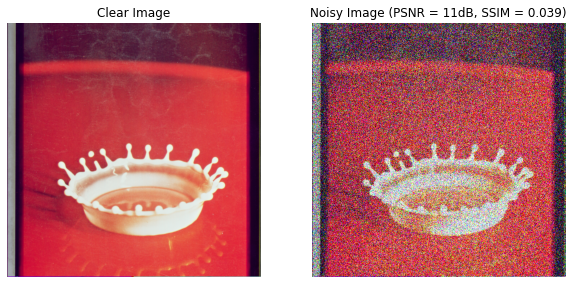

In [10]:
img = imread(os.path.join("images", "Splash.tiff"))
H, W, C = img.shape

sigma = 100.0
img_noise = np.clip((img + sigma * np.random.randn(*img.shape)).round(), 0, 255).astype(
    np.uint8
)

print(f"Size: {img.shape}")

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

ax = axes[0]
ax.axis("off")
ax.set_title("Clear Image")
ax.imshow(img)

ax = axes[1]
ax.axis("off")
ax.set_title(
    f"Noisy Image (PSNR = {psnr(img, img_noise):.2g}dB, SSIM = {ssim(img, img_noise):.2g})"
)
ax.imshow(img_noise)

plt.show()

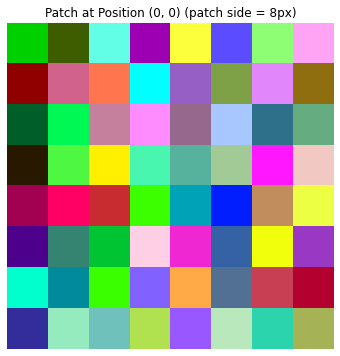

In [11]:
patch_size = 8

img_patched = stack_image(img_noise, patch_size)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

pos = (0, 0)
ax.set_title(f"Patch at Position {pos} (patch side = {patch_size}px)")
ax.axis("off")
ax.imshow(img_patched[pos])

plt.show()

In [12]:
Y = img_noise
mean, std = Y.mean(axis=(0, 1)), Y.std(axis=(0, 1))
Y = ((Y - mean) / std).astype(np.float32)

In [ ]:
rho = 20.0
max_iter = 100
rank = [1, 20, 3, 1]

res = matrix_product_state(Y, rank=rank)

print("Tensor Train ranks (flat image):")
for x in res.factors:
    print("  *", x.shape)

X_flat, _, _, errs_flat = admm(
    Y,
    tt_decomposer(rank=rank),
    rho=rho,
    max_iter=max_iter,
)

In [14]:
rho = 20.0
max_iter = 100
rank = [1, 20, 4, 4, 3, 1]

Y_stacked = stack_image(Y, patch_size)

res = matrix_product_state(Y_stacked, rank=rank)

print("Tensor Train ranks (stacked image):")
for x in res.factors:
    print("  *", x.shape)

X, _, _, errs = admm(
    Y,
    stacked_decomposer(tt_decomposer(rank=rank), patch_size),
    rho=rho,
    max_iter=max_iter,
)

Tensor Train ranks (stacked image):
  * (1, 64, 20)
  * (20, 64, 4)
  * (4, 8, 4)
  * (4, 8, 3)
  * (3, 3, 1)


100%|██████████| 100/100 [00:05<00:00, 18.50it/s]


In [15]:
img_recovered = (X * std + mean).round().astype(np.uint8).clip(0, 255)
img_recovered_flat = (X_flat * std + mean).round().astype(np.uint8).clip(0, 255)
img_refined = refine(img_recovered)
img_blurred = cv2.GaussianBlur(img_noise, (9, 9), cv2.BORDER_DEFAULT)

In [16]:
def plot_img(ax, img, img_gt, title):
    textstr = f"PSNR = {psnr(img_gt, img):.2g}dB\nSSIM = {ssim(img_gt, img):.2g}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)

    ax.axis("off")
    ax.set_title(title, fontdict={"fontsize": 14})
    ax.imshow(img)

    ax.text(
        0.70,
        0.10,
        textstr,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

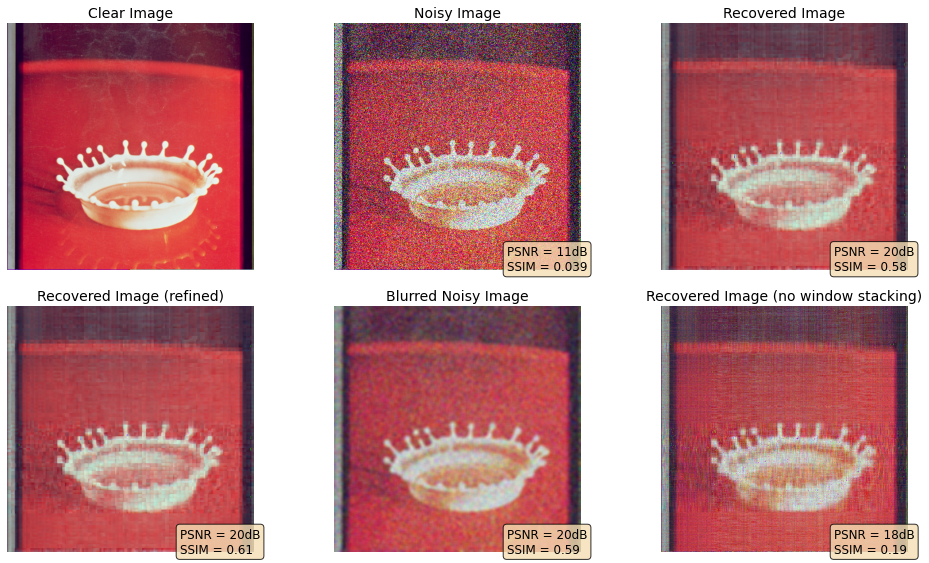

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()

ax = axes[0]
ax.axis("off")
ax.set_title("Clear Image", fontdict={"fontsize": 14})
ax.imshow(img)

ax = axes[1]
plot_img(ax, img_noise, img, "Noisy Image")

ax = axes[2]
plot_img(ax, img_recovered, img, "Recovered Image")

ax = axes[3]
plot_img(ax, img_refined, img, "Recovered Image (refined)")

ax = axes[4]
plot_img(ax, img_blurred, img, "Blurred Noisy Image")

ax = axes[5]
plot_img(ax, img_recovered_flat, img, "Recovered Image (no window stacking)")

fig.tight_layout()
fig.savefig(os.path.join("results", "denoising.png"))

plt.show()

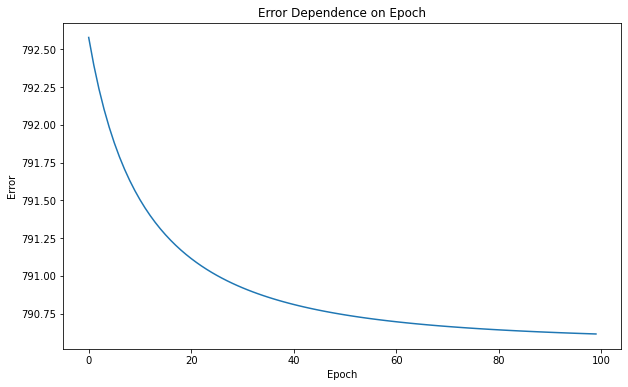

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.set_xlabel("Epoch")
ax.set_ylabel("Error")
ax.set_title("Error Dependence on Epoch")
ax.plot(errs)

fig.savefig("loss.png")

plt.show()

In [19]:
def get_metrics(
    img_name,
    sigma,
    rho=20.0,
    rank=[1, 20, 4, 4, 3, 1],
    rank_flat=[1, 20, 3, 1],
    max_iter=100,
    patch_size=8,
):
    img = imread(os.path.join("test_img", img_name))

    img_noise = np.clip(
        (img + sigma * np.random.randn(*img.shape)).round(), 0, 255
    ).astype(np.uint8)

    Y = img_noise
    mean, std = Y.mean(axis=(0, 1)), Y.std(axis=(0, 1))
    Y = ((Y - mean) / std).astype(np.float32)

    # X_flat, _, _, errs_flat = admm(
    #     Y, tt_decomposer(rank=rank_flat), rho=rho, max_iter=max_iter, disable=True
    # )

    X, _, _, errs = admm(
        Y,
        stacked_decomposer(tt_decomposer(rank=rank), patch_size),
        rho=rho,
        max_iter=max_iter,
        disable=True,
    )

    img_recovered = (X * std + mean).round().astype(np.uint8).clip(0, 255)
    # img_recovered_flat = (X_flat * std + mean).round().astype(np.uint8).clip(0, 255)
    img_refined = refine(img_recovered)
    img_blurred = cv2.GaussianBlur(img_noise, (9, 9), cv2.BORDER_DEFAULT)

    images = {
        "noisy": img_noise,
        "tensor_train_stacked": img_recovered,
        # "tensor_train": img_recovered_flat,
        "tensor_train_stacked_upscale": img_refined,
        "noisy_blurred": img_blurred,
    }

    results = []
    for method, img_cur in images.items():
        row = {"method": method, "psnr": psnr(img, img_cur), "ssim": ssim(img, img_cur)}
        results.append(row)

    return pd.DataFrame(results)

In [20]:
from itertools import product

filenames = ["House.tiff", "Lenna.png", "Mandrill.tiff", "Peppers.tiff", "Splash.tiff"]
sigmas = np.linspace(10, 100, num=10)

results = []
for fname, sigma in tqdm(
    product(filenames, sigmas), total=len(filenames) * len(sigmas)
):
    img_name = fname.split(".")[0]
    df = get_metrics(fname, sigma)
    df["image"] = img_name
    df["sigma"] = sigma

    results.append(df)

results = pd.concat(results)
results.to_csv("results/metrics.csv")

  2%|▏         | 1/50 [00:03<02:51,  3.51s/it]

In [21]:
results

,method,psnr,ssim,image,sigma
0,noisy,28.124970,0.622113,House,10.0
1,tensor_train_stacked,23.672570,0.623210,House,10.0
2,tensor_train_stacked_upscale,24.053298,0.645699,House,10.0
3,noisy_blurred,24.386345,0.694062,House,10.0
0,noisy,22.170223,0.370328,House,20.0
...,...,...,...,...,...
3,noisy_blurred,21.340902,0.610546,Splash,90.0
0,noisy,10.573631,0.039840,Splash,100.0
1,tensor_train_stacked,20.441992,0.582220,Splash,100.0
2,tensor_train_stacked_upscale,20.522842,0.609812,Splash,100.0


100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


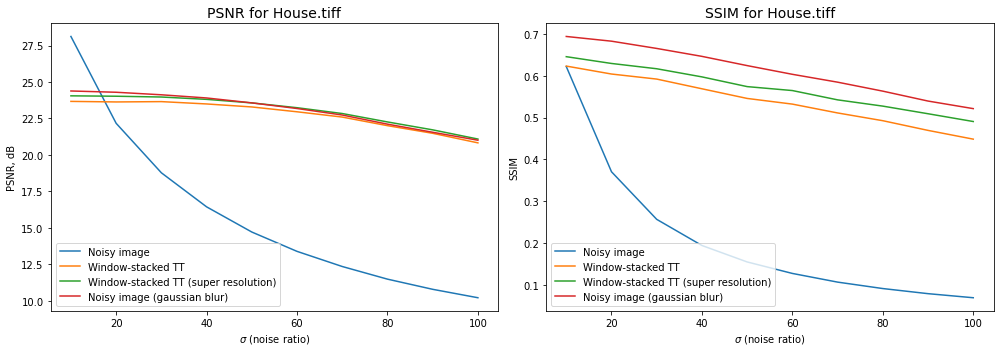

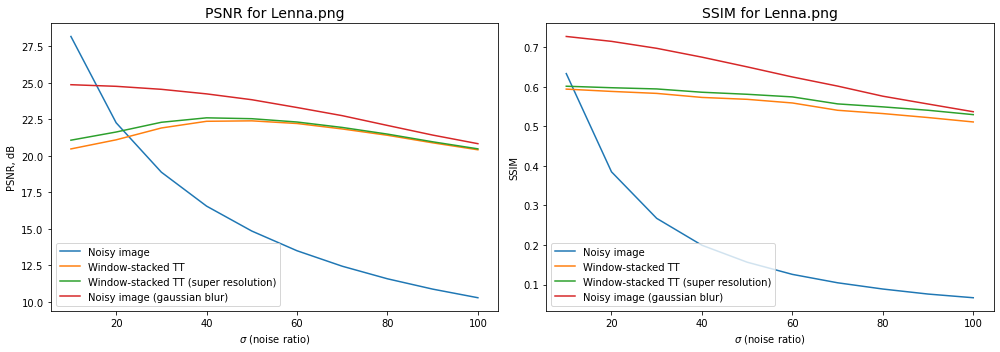

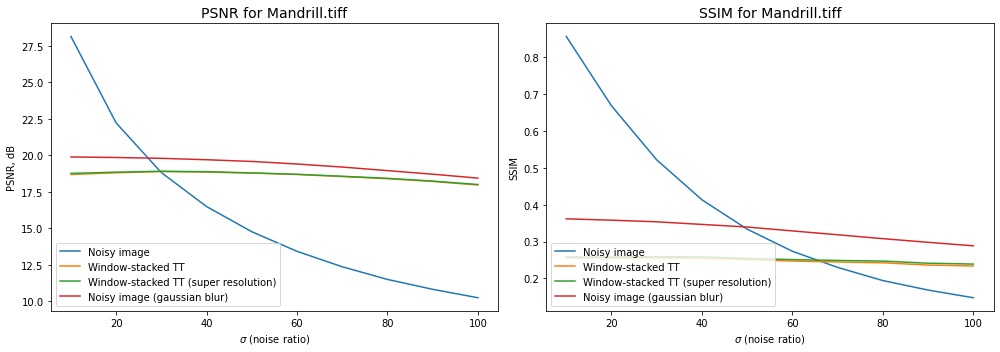

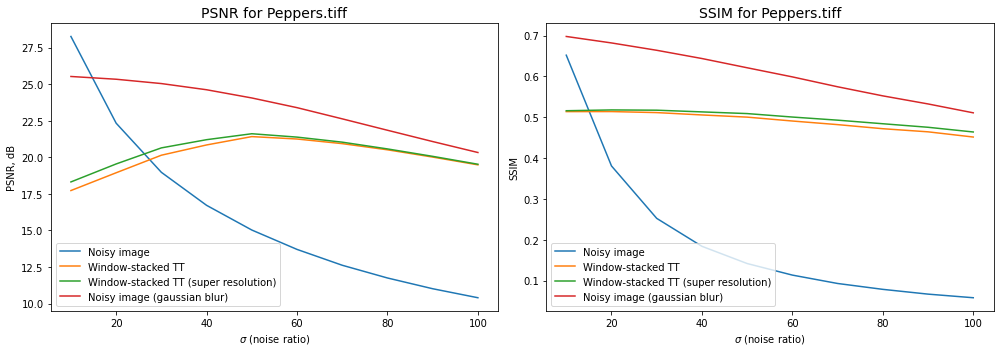

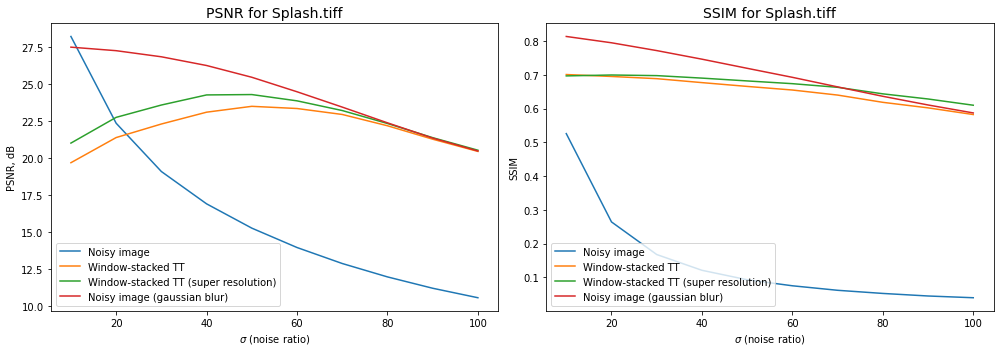

In [32]:
filenames = ["House.tiff", "Lenna.png", "Mandrill.tiff", "Peppers.tiff", "Splash.tiff"]
methods = {
    "noisy": "Noisy image",
    "tensor_train_stacked": "Window-stacked TT",
    "tensor_train_stacked_upscale": "Window-stacked TT (super resolution)",
    "noisy_blurred": "Noisy image (gaussian blur)",
}
results = pd.read_csv("results/metrics.csv", index_col=0)

for fname in tqdm(filenames, total=len(filenames)):
    img_name = fname.split(".")[0]
    df = results[results["image"] == img_name].sort_values("sigma")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.set_title(f"PSNR for {fname}", fontdict={"fontsize": 14})
    ax.set_xlabel(r"$\sigma$ (noise ratio)")
    ax.set_ylabel("PSNR, dB")

    ax = axes[1]
    ax.set_title(f"SSIM for {fname}", fontdict={"fontsize": 14})
    ax.set_xlabel(r"$\sigma$ (noise ratio)")
    ax.set_ylabel("SSIM")

    for method in methods:
        df_masked = df[df["method"] == method]
        axes[0].plot(df_masked["sigma"], df_masked["psnr"], label=methods[method])
        axes[1].plot(df_masked["sigma"], df_masked["ssim"], label=methods[method])

    axes[0].legend(loc="lower left")
    axes[1].legend(loc="lower left")

    fig.tight_layout()
    fig.savefig(os.path.join("results", f"{img_name.lower()}_metrics"))